# Project5: Niraj 
## Modeling Accident time series - Vector AutoRegression model



In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.stattools import acf

from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.cluster import KMeans

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.api import VAR

# Import dates_from_str and convert "quarterly" into dates.
from statsmodels.tsa.base.datetools import dates_from_str


In [59]:
# Read the saved csv from the earlier notebook and set the index to the date_time column

df_accident_ts = pd.read_csv("./data/accident_ts_10years.csv", parse_dates= ['date_time'], index_col="date_time")

/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (3,6,8,11,20,24,26,28,30,32,34,36,38,40,42,44,48,50,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [60]:
df_accident_ts.reset_index()
df_accident_ts.sort_index(inplace=True)

In [61]:
type( df_accident_ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [62]:
# DateTime index should be like: DatetimeIndex: 102385 entries, 2018-01-05 06:00:00 to 2020-12-24 09:25:00
df_accident_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353764 entries, 2010-01-01 00:01:00 to 2020-12-31 23:51:00
Data columns (total 52 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 353764 non-null  int64  
 1   month                353764 non-null  int64  
 2   monthname            203465 non-null  object 
 3   day                  353764 non-null  int64  
 4   day_week             353764 non-null  int64  
 5   day_weekname         203465 non-null  object 
 6   hour                 353764 non-null  int64  
 7   hourname             203465 non-null  object 
 8   minute               353764 non-null  int64  
 9   state                353764 non-null  int64  
 10  statename            203465 non-null  object 
 11  county               353764 non-null  int64  
 12  st_case              353764 non-null  int64  
 13  ve_total             353764 non-null  int64  
 14  ve_forms             353764 non-nu

In [63]:
 df_accident_ts.head() # nothing exciting...

year  month monthname  day  day_week day_weekname  hour  \
date_time                                                                      
2010-01-01 00:01:00  2010      1       NaN    1         6          NaN     0   
2010-01-01 00:07:00  2010      1       NaN    1         6          NaN     0   
2010-01-01 00:17:00  2010      1       NaN    1         6          NaN     0   
2010-01-01 00:17:00  2010      1       NaN    1         6          NaN     0   
2010-01-01 00:19:00  2010      1       NaN    1         6          NaN     0   

                    hourname  minute  state  ... arr_min  arr_minname  fatals  \
date_time                                    ...                                
2010-01-01 00:01:00      NaN       1     15  ...      23          NaN       1   
2010-01-01 00:07:00      NaN       7     35  ...      99          NaN       2   
2010-01-01 00:17:00      NaN      17     28  ...       3          NaN       1   
2010-01-01 00:17:00      NaN      17     37  ...      99          NaN       1   
2010-01-01 00:19:00      NaN      19     39  ...      34          NaN       1   

                     drunk_dr  day_3hr_window  day_3hr_window_name  \
date_time                                                            
2010-01-01 00:01:00         1              41                  NaN   
2010-01-01 00:07:00         2              41                  NaN   
2010-01-01 00:17:00         1              41                  NaN   
2010-01-01 00:17:00         1              41                  NaN   
2010-01-01 00:19:00         1              41                  NaN   

                     day_2hr_window  day_2hr_window_name  day_4hr_window  \
date_time                                                                  
2010-01-01 00:01:00              61                  NaN              31   
2010-01-01 00:07:00              61                  NaN              31   
2010-01-01 00:17:00              61                  NaN              31   
2010-01-01 00:17:00              61                  NaN              31   
2010-01-01 00:19:00              61                  NaN              31   

                    day_4hr_window_name  
date_time                                
2010-01-01 00:01:00                 NaN  
2010-01-01 00:07:00                 NaN  
2010-01-01 00:17:00                 NaN  
2010-01-01 00:17:00                 NaN  
2010-01-01 00:19:00                 NaN  

[5 rows x 52 columns]

In [64]:
# Drop Unnamed column if it exists
#df_accident_ts.drop(columns="Unnamed: 0", inplace=True)

In [65]:
df_accident_ts.isnull().sum()

year                        0
month                       0
monthname              150299
day                         0
day_week                    0
day_weekname           150299
hour                        0
hourname               150299
minute                      0
state                       0
statename              150299
county                      0
st_case                     0
ve_total                    0
ve_forms                    0
pvh_invl                30075
peds                        0
persons                     0
city                        0
cityname               182586
latitude                    0
longitud                    0
harm_ev                     0
harm_evname            150299
man_coll                    0
man_collname           150299
wrk_zone                    0
wrk_zonename           150299
rel_road                    0
rel_roadname           150299
lgt_cond                    0
lgt_condname           150299
weather                     0
weathernam

In [66]:
df_accident_ts.index.isnull().sum() # removed all nulls before creating the index and saving to csv (in earlier notebook)

0

In [67]:
# See relavant accident data 
df_accident_ts[['year', "month", "day_week", "hour", "minute", "day_3hr_window", "day_3hr_window_name", "fatals", "drunk_dr"]]
#df_accident_ts[['year', "month", "day", "hour", "minute", "date_time", "day_3hr_window"]]

year  month  day_week  hour  minute  day_3hr_window  \
date_time                                                                  
2010-01-01 00:01:00  2010      1         6     0       1              41   
2010-01-01 00:07:00  2010      1         6     0       7              41   
2010-01-01 00:17:00  2010      1         6     0      17              41   
2010-01-01 00:17:00  2010      1         6     0      17              41   
2010-01-01 00:19:00  2010      1         6     0      19              41   
...                   ...    ...       ...   ...     ...             ...   
2020-12-31 23:32:00  2020     12         5    23      32              40   
2020-12-31 23:36:00  2020     12         5    23      36              40   
2020-12-31 23:50:00  2020     12         5    23      50              40   
2020-12-31 23:50:00  2020     12         5    23      50              40   
2020-12-31 23:51:00  2020     12         5    23      51              40   

                         day_3hr_window_name  fatals  drunk_dr  
date_time                                                       
2010-01-01 00:01:00                      NaN       1         1  
2010-01-01 00:07:00                      NaN       2         2  
2010-01-01 00:17:00                      NaN       1         1  
2010-01-01 00:17:00                      NaN       1         1  
2010-01-01 00:19:00                      NaN       1         1  
...                                      ...     ...       ...  
2020-12-31 23:32:00  Thursday 21:00 to 24:00       1         0  
2020-12-31 23:36:00  Thursday 21:00 to 24:00       1         0  
2020-12-31 23:50:00  Thursday 21:00 to 24:00       1         0  
2020-12-31 23:50:00  Thursday 21:00 to 24:00       1         0  
2020-12-31 23:51:00  Thursday 21:00 to 24:00       1         1  

[353764 rows x 9 columns]

### Draw graphs showing fatalities in our 2-, 3- and 4-hour windows

<AxesSubplot:>

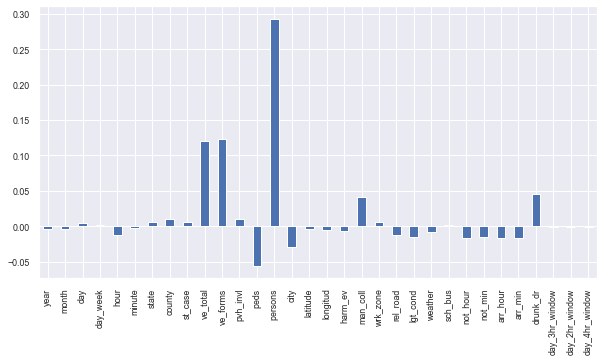

In [68]:

plt.figure(figsize=(10,5));
df_accident_ts.drop(columns="fatals").corrwith(df_accident_ts['fatals']).plot(kind='bar', sort_columns=True)



#### **Interpretation:**
Fatals is positively correlated to drunk_dr, persons, ve_total (same as ve_forms), maneuver to avoid collision, work_zone, and negatively correlated to peds, weather and light condition. 
Use these for modeling. 

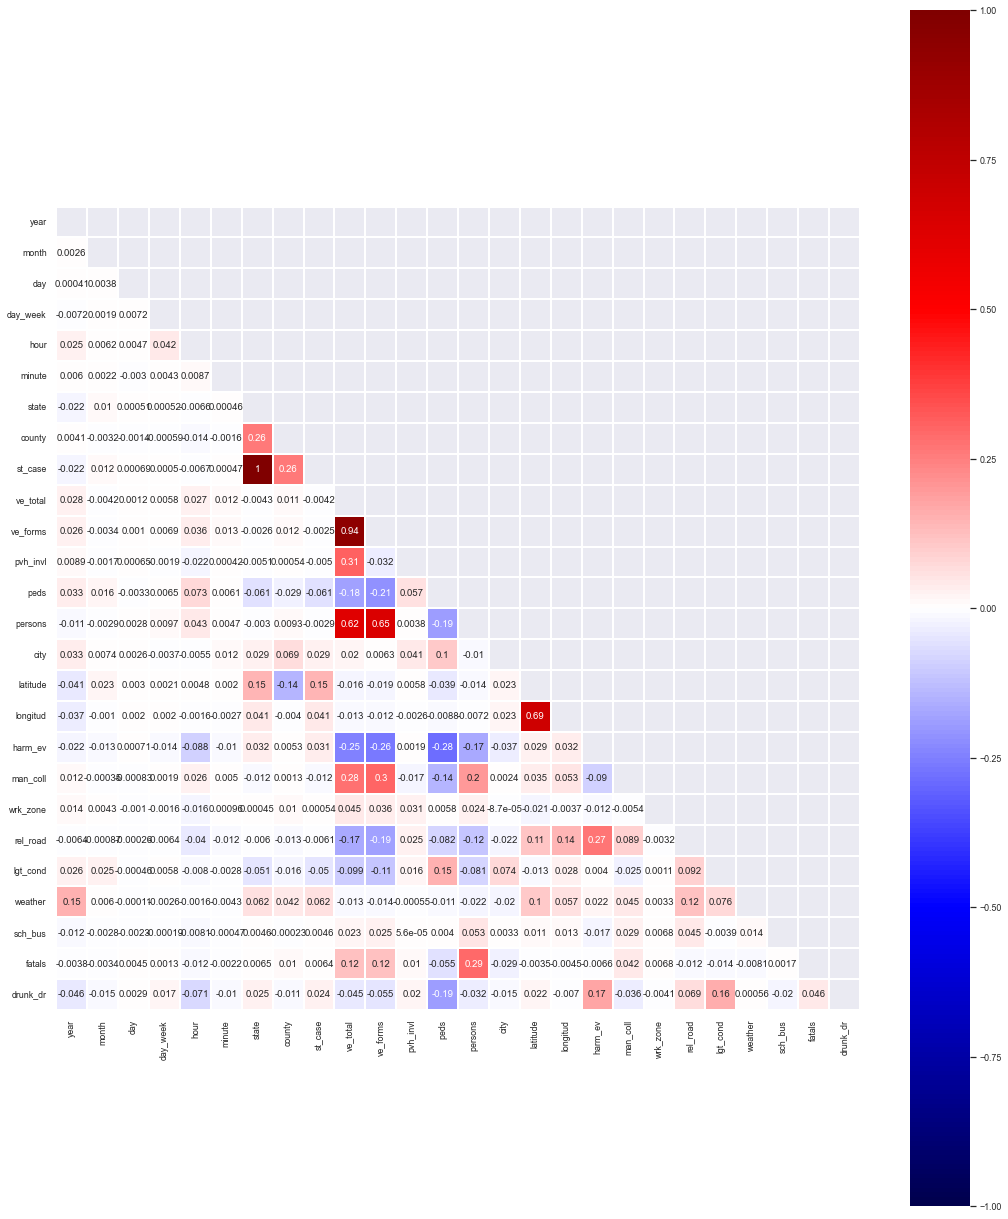

In [69]:
# heatmap showing correlation for all columns. 
# ToDo: change to jsut few columns used in the model

corr = df_accident_ts.drop( columns=["day_3hr_window", "day_2hr_window", "day_4hr_window", "not_hour", "not_min", "arr_hour", "arr_min"]).corr()
plt.figure(figsize=(18,22))

sns.set(font_scale=0.8)

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr, cmap='seismic', annot=True, square=True,
            vmin = -1, vmax = 1, mask = mask,
            linecolor='white', linewidths=0.1);

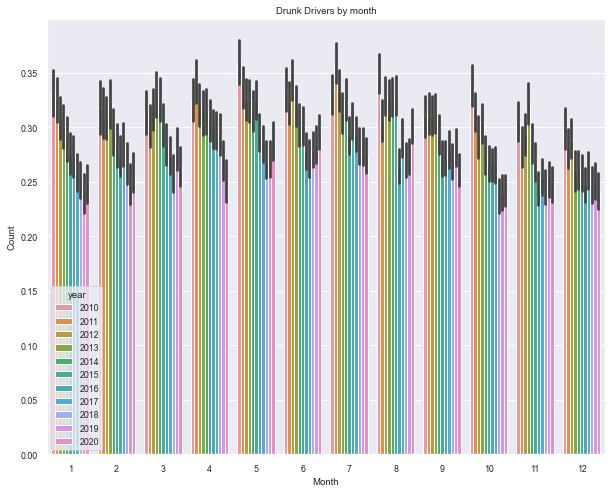

In [70]:
plt.figure(figsize=(10,8))


sns.barplot(data = df_accident_ts, x = 'month', y = 'drunk_dr', hue = 'year', orient="v");
#sns.barplot(data = df_a_top_C, x = 'median_income', y = 'pct_bench', hue = 'county_name', orient="v");

plt.title("Drunk Drivers by month")
plt.ylabel("Count")
plt.xlabel("Month");
#plt.ylim(60, 90);



In [71]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    legend_list = []
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        legend_list.append(col)
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=12)
    
    plt.legend(legend_list);

In [72]:
# Create new df for modeling which has the columns we need, by month
df_model = df_accident_ts.resample("M").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

In [73]:
# Create new df for modeling which has the columns we need, by week
df_model_week = df_accident_ts.resample("W").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

In [74]:
# Create new df for modeling which has the columns we need, by day 
df_model_day = df_accident_ts.resample("D").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

In [75]:
# Create new df for modeling which has the columns we need, by 3 hour window

df_model_3hour = df_accident_ts.resample("3H").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]


In [76]:
print( df_model.sum(), df_model_week.sum(), df_model_day.sum()), 

fatals      384829
drunk_dr    102679
peds         75855
ve_total    549158
persons     799929
dtype: int64 fatals      384829
drunk_dr    102679
peds         75855
ve_total    549158
persons     799929
dtype: int64 fatals      384829
drunk_dr    102679
peds         75855
ve_total    549158
persons     799929
dtype: int64


(None,)

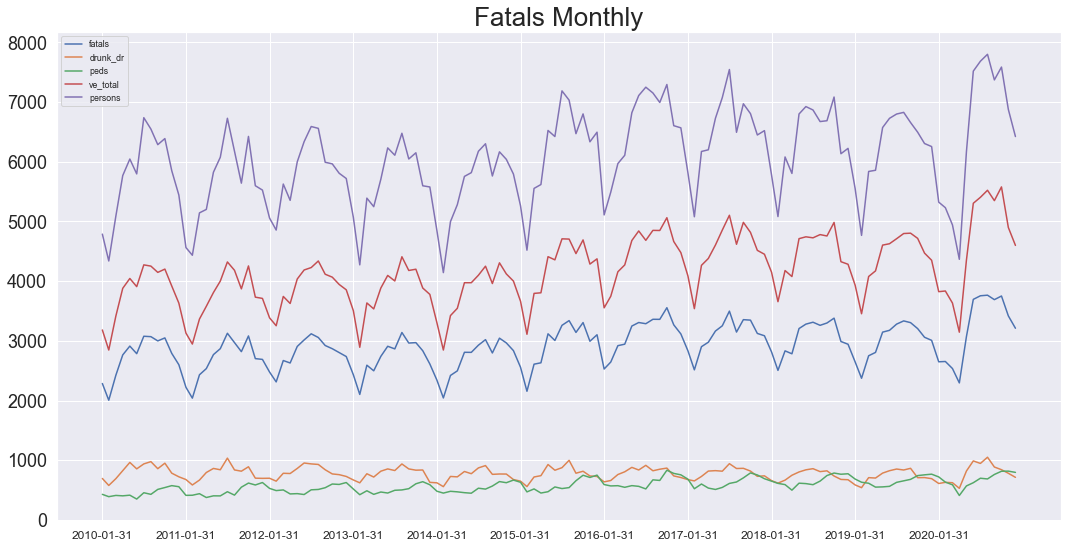

In [77]:
# 
plot_series(df_model, cols=["fatals", "drunk_dr", "peds", "ve_total", "persons" ], title="Fatals Monthly", steps = 12)

#### **Interpretation:**
Notice the sharp drop during the initial Covid lockdown period of March-April 2020.   
The number of fatalities and drinking drivers along with all the other variables increased thereafter and soon exceeded the pre-Covid levels

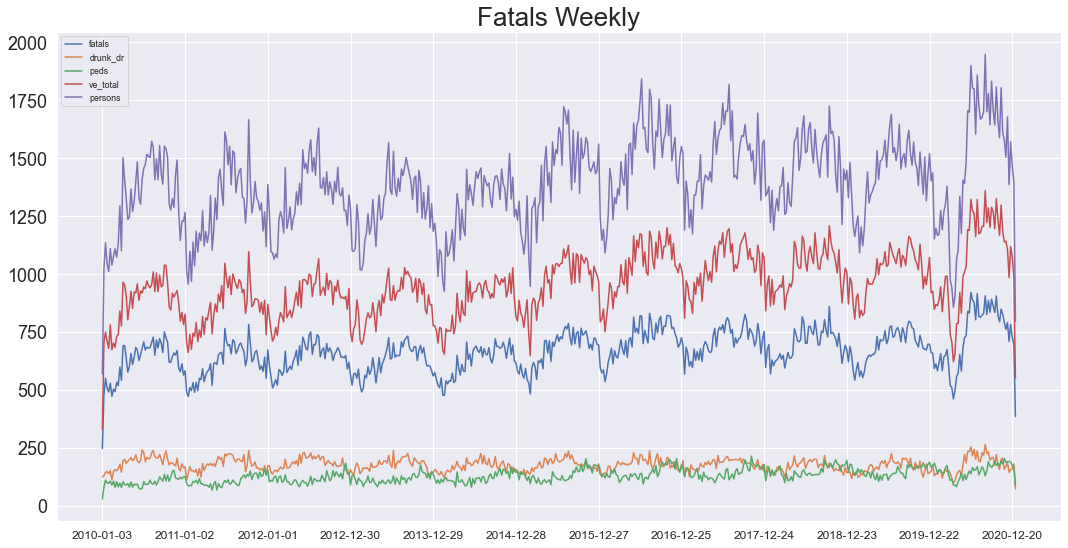

In [78]:
# 
plot_series(df_model_week, cols=["fatals", "drunk_dr", "peds", "ve_total", "persons" ], title="Fatals Weekly", steps = 52)

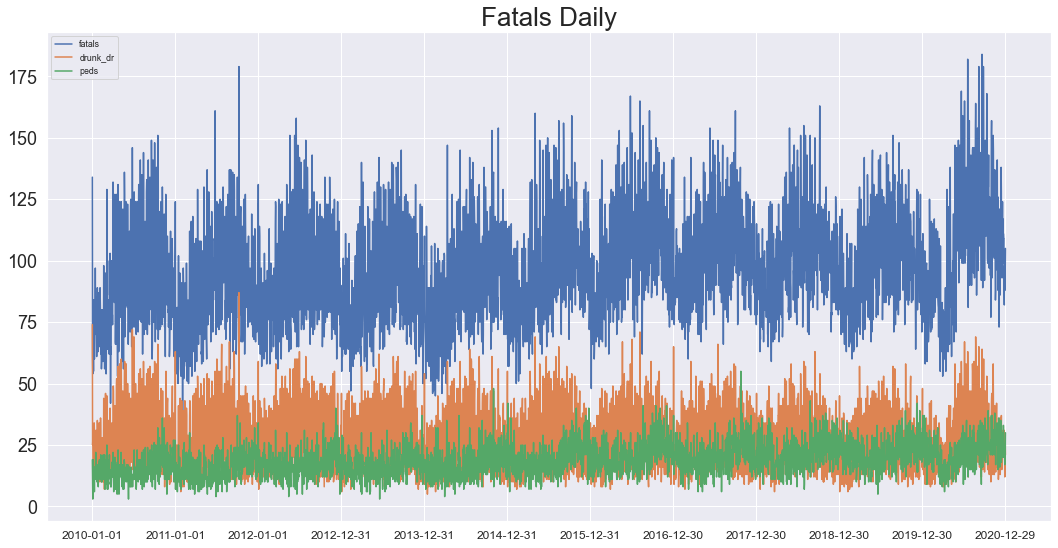

In [79]:
plot_series(df_model_day, cols=["fatals", "drunk_dr", "peds" ], title="Fatals Daily", steps = 365)


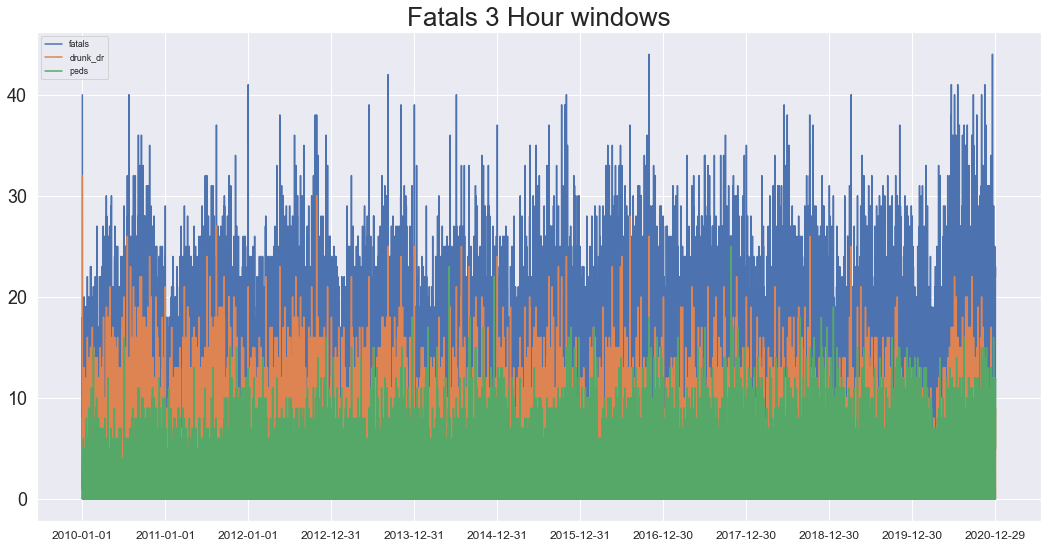

In [80]:
plot_series(df_model_3hour, cols=["fatals", "drunk_dr", "peds" ], title="Fatals 3 Hour windows", steps = 365*8)

#### **Interpretation:**
Note the steep variance in the 3 hour windows compared to the daily or other time periods. These reflect the weekend late night and holiday spikes. 

In [81]:
df_model_week.head()

fatals  drunk_dr  peds  ve_total  persons
date_time                                            
2010-01-03     249       126    31       333      570
2010-01-10     482       133    84       707     1024
2010-01-17     552       146   113       751     1136
2010-01-24     509       149   101       711     1045
2010-01-31     493       140    99       680     1013

In [82]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [83]:
interpret_dftest(adfuller(df_model['fatals']))

Test Statistic    -0.319634
p-value            0.922677
Lag Used          12.000000
dtype: float64

In [84]:
interpret_dftest(adfuller(df_model['fatals'].diff().dropna())) # Yay, stationary!! 

Test Statistic    -5.490023
p-value            0.000002
Lag Used          11.000000
dtype: float64

In [85]:
# Create column.

df_model['first_diff_fatals'] = df_model['fatals'].diff()

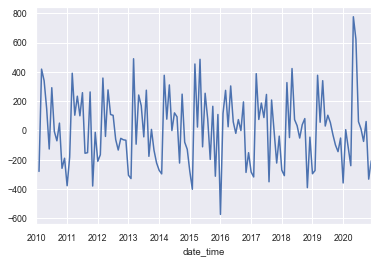

In [86]:
df_model['first_diff_fatals'].plot();

In [87]:
interpret_dftest(adfuller(df_model['drunk_dr']))

Test Statistic    -1.994409
p-value            0.289030
Lag Used          12.000000
dtype: float64

In [88]:
interpret_dftest(adfuller(df_model['drunk_dr'].diff().dropna())) # Yay, stationary!! 

Test Statistic    -4.304375
p-value            0.000437
Lag Used          13.000000
dtype: float64

In [89]:
# Create column.

df_model['first_diff_drunk_dr'] = df_model['drunk_dr'].diff()

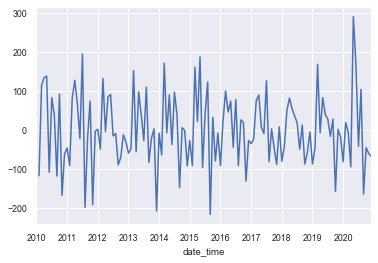

In [90]:
df_model['first_diff_drunk_dr'].plot();

In [91]:
interpret_dftest(adfuller(df_model['peds']))

Test Statistic    -0.816308
p-value            0.814285
Lag Used          11.000000
dtype: float64

In [92]:
interpret_dftest(adfuller(df_model['peds'].diff().dropna())) # Yay, stationary!! 

Test Statistic   -1.125372e+01
p-value           1.687178e-20
Lag Used          1.000000e+01
dtype: float64

In [93]:
# Create column.

df_model['first_diff_peds'] = df_model['peds'].diff()

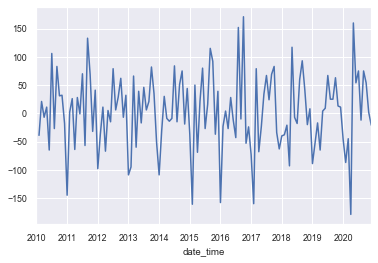

In [94]:
df_model['first_diff_peds'].plot();

In [95]:
df_model.head()

fatals  drunk_dr  peds  ve_total  persons  first_diff_fatals  \
date_time                                                                  
2010-01-31    2285       694   428      3182     4788                NaN   
2010-02-28    2005       577   389      2846     4338             -280.0   
2010-03-31    2424       691   410      3416     5091              419.0   
2010-04-30    2764       825   403      3880     5769              340.0   
2010-05-31    2912       963   414      4045     6046              148.0   

            first_diff_drunk_dr  first_diff_peds  
date_time                                         
2010-01-31                  NaN              NaN  
2010-02-28               -117.0            -39.0  
2010-03-31                114.0             21.0  
2010-04-30                134.0             -7.0  
2010-05-31                138.0             11.0

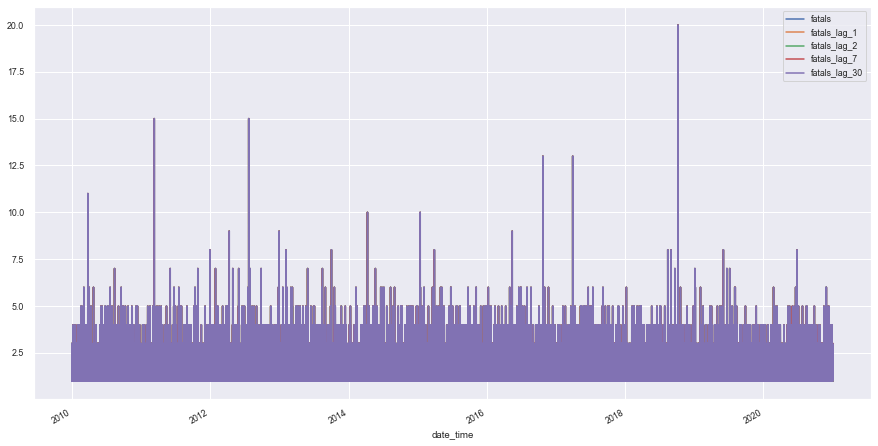

In [96]:
df_accident_ts["fatals_lag_1"] = df_accident_ts["fatals"].shift(1)
df_accident_ts["fatals_lag_2"] = df_accident_ts["fatals"].shift(2)
df_accident_ts["fatals_lag_7"] = df_accident_ts["fatals"].shift(7)
df_accident_ts["fatals_lag_30"] = df_accident_ts["fatals"].shift(30)

df2 = df_accident_ts[['fatals', 'fatals_lag_1', 'fatals_lag_2', 'fatals_lag_7', 'fatals_lag_30']].dropna()

df2.plot(figsize=(15,8));

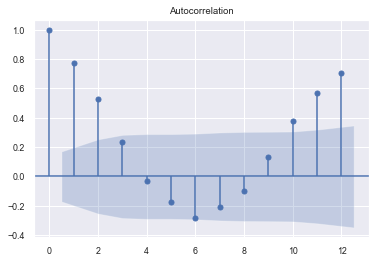

In [97]:
# One year trends
plot_acf( df_model['fatals'], lags=12); # blue shaed area is confidence interval. 
# If the datapoints are outside the CI, they are statistically significant and can be used in the model

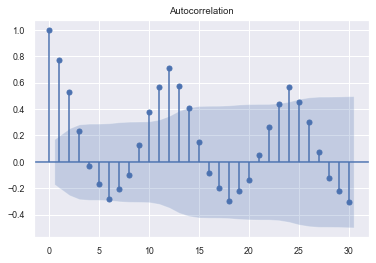

In [98]:
plot_acf( df_model['fatals'], lags=30); 


#### **Interpretation** : 
The coefficient of correlation between two values in a time series, called the autocorrelation function (ACF) is used to identify seasonality in our time series data. 

Notice how the coefficient is high at lags 12, 24 (which is a one year interval in our monthly timeseries)
We will focus on the points that lie beyond the blue region as they signify strong statistical significance.



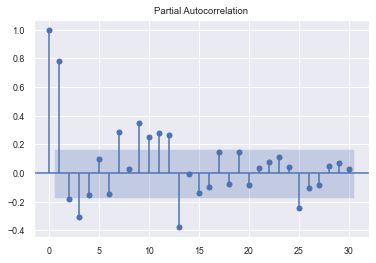

In [99]:
# Generate the PACF plot 

plot_pacf( df_model['fatals'], lags=30); # blue shaed area is confidence interval. If the datapoints are outside the CI, they are statitically significant and can be usedin the model


#### **Interpretation** : 
Datapoints outside the Confidence Interval (blue shaded area) can be used in the model
Notice the spikes at lags 12 and 24

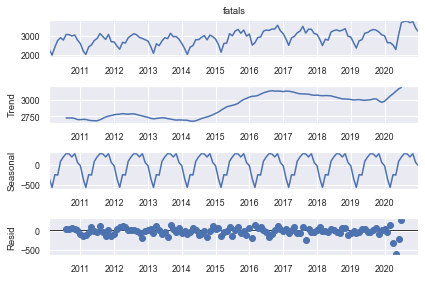

In [100]:
decomp = seasonal_decompose(df_model['fatals'])

decomp.plot();



#### **Interpretation** : 

Seasonal Decomposition of Fatals. Nice seasonality - summer months have higher fatalities, Jan-Feb is the dip. Number of miles driven is 10-20% lower in these 2 winter months as compared to the summer (external research)


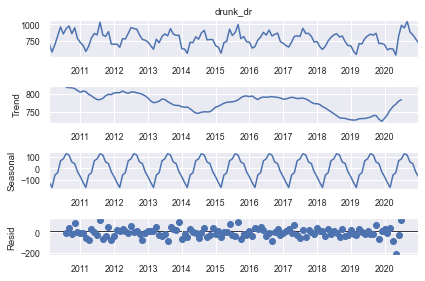

In [101]:
decomp = seasonal_decompose(df_model['drunk_dr'])

decomp.plot();


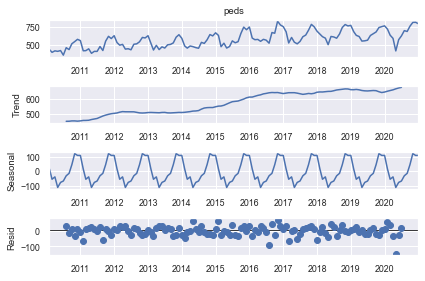

In [102]:
decomp = seasonal_decompose(df_model['peds'])

decomp.plot();


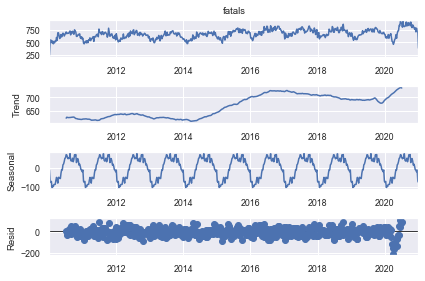

In [103]:
decomp = seasonal_decompose(df_model_week['fatals'])

decomp.plot();



#### **Interpretation** : 

Seasonal Decomposition of Fatals. Nice seasonality - summer months have higher fatalities, Jan-Feb is the dip. Number of miles driven is 10-20% lower in these 2 winter months as compared to the summer. 


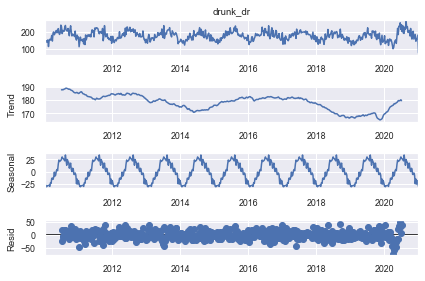

In [104]:
decomp = seasonal_decompose(df_model_week['drunk_dr'])

decomp.plot();


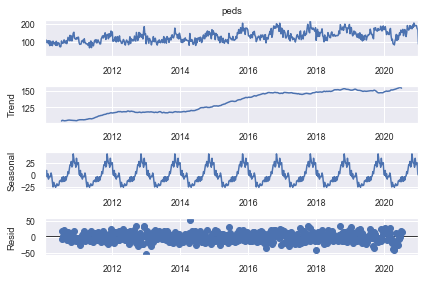

In [105]:
decomp = seasonal_decompose(df_model_week['peds'])

decomp.plot();


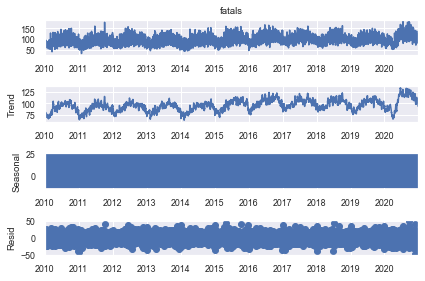

In [106]:
decomp = seasonal_decompose(df_model_day['fatals'])
decomp.plot();

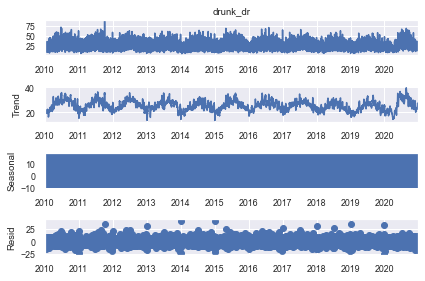

In [107]:
decomp = seasonal_decompose(df_model_day['drunk_dr'])
decomp.plot();

### Let's Model! 


### Train test Split

In [108]:
df_model.head()

fatals  drunk_dr  peds  ve_total  persons  first_diff_fatals  \
date_time                                                                  
2010-01-31    2285       694   428      3182     4788                NaN   
2010-02-28    2005       577   389      2846     4338             -280.0   
2010-03-31    2424       691   410      3416     5091              419.0   
2010-04-30    2764       825   403      3880     5769              340.0   
2010-05-31    2912       963   414      4045     6046              148.0   

            first_diff_drunk_dr  first_diff_peds  
date_time                                         
2010-01-31                  NaN              NaN  
2010-02-28               -117.0            -39.0  
2010-03-31                114.0             21.0  
2010-04-30                134.0             -7.0  
2010-05-31                138.0             11.0

In [109]:

# Subset our data.
df_ts = df_model[['first_diff_fatals', 'first_diff_drunk_dr', 'first_diff_peds']]

# Let's get rid of rows containing missing values.
df_ts.dropna(inplace = True)

/var/folders/06/2ml34kbd5jbg6988jmpwrgz00r_kcc/T/ipykernel_14921/1889299326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts.dropna(inplace = True)


In [110]:
df_ts

first_diff_fatals  first_diff_drunk_dr  first_diff_peds
date_time                                                          
2010-02-28             -280.0               -117.0            -39.0
2010-03-31              419.0                114.0             21.0
2010-04-30              340.0                134.0             -7.0
2010-05-31              148.0                138.0             11.0
2010-06-30             -127.0               -108.0            -65.0
...                       ...                  ...              ...
2020-08-31               10.0                104.0            -12.0
2020-09-30              -75.0               -164.0             75.0
2020-10-31               61.0                -45.0             54.0
2020-11-30             -333.0                -60.0              2.0
2020-12-31             -207.0                -68.0            -21.0

[131 rows x 3 columns]

In [111]:
train, test = train_test_split(df_ts, shuffle=False, 
                               test_size = 0.05) # use small test size, as we can't predict far into the future; change for weekly too....

# do daily too, very little data 


In [112]:
# Instantiate a VAR model. 

model = VAR(train, dates = train.index, freq='M')

In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-02-28 to 2020-05-31
Freq: M
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_diff_fatals    124 non-null    float64
 1   first_diff_drunk_dr  124 non-null    float64
 2   first_diff_peds      124 non-null    float64
dtypes: float64(3)
memory usage: 3.9 KB


In [114]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit( maxlags=15, # what is the largest possible value of p?
                     ic="aic")   # what "information criterion" (ic) will we use to decide what's "best?"

In [115]:
# What is the order of our autoregressive model? 
ts_model.k_ar

13

In [116]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 12, Apr, 2022
Time:                     00:06:54
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    27.3173
Nobs:                     111.000    HQIC:                   25.5763
Log likelihood:          -1706.04    FPE:                4.32248e+10
AIC:                      24.3880    Det(Omega_mle):     1.71700e+10
--------------------------------------------------------------------
Results for equation first_diff_fatals
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -6.796099        15.614924           -0.435           0.663
L1.first_diff_fatals           -0.492131         0.195209           -2.521           0.012
L1.first

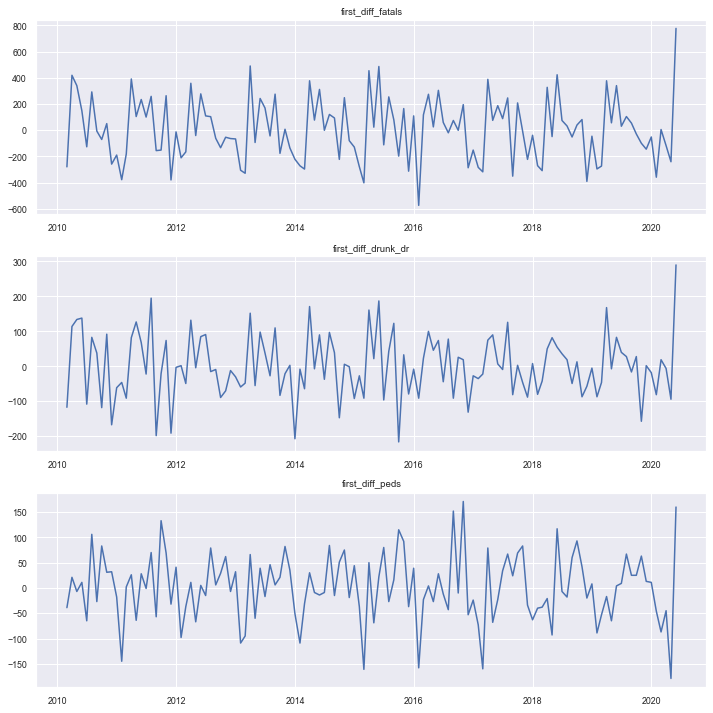

In [117]:
# Plot our training data.
ts_model.plot();
plt.tight_layout()

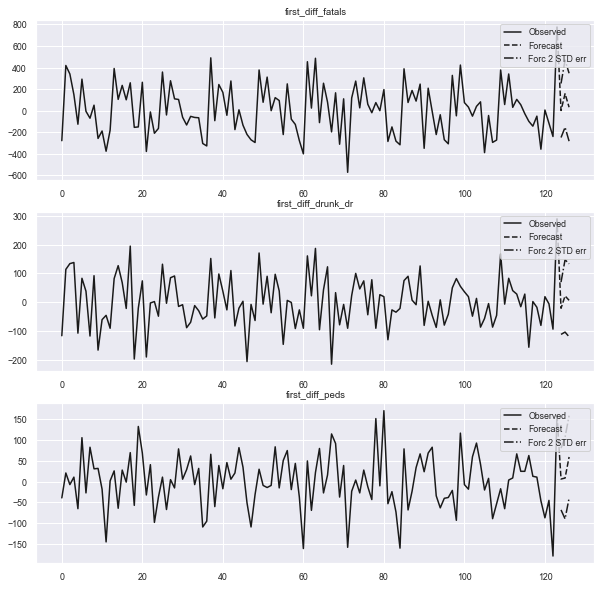

In [118]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);


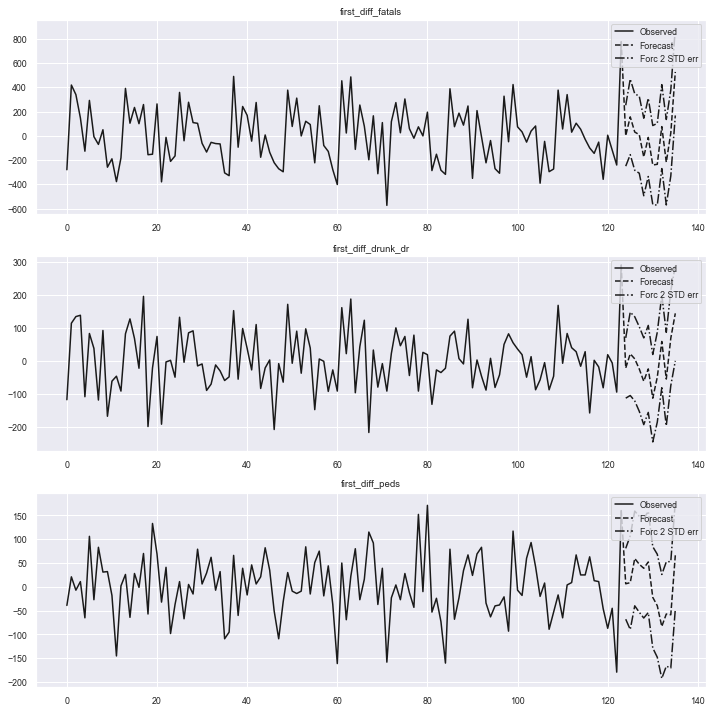

In [119]:
# Plot the forecast looking 12 steps ahead.

ts_model.plot_forecast(12);
plt.tight_layout()

In [120]:
""" 
## Now let's plot our undifferenced forecasts against the actual values and compare
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (8,6))

for i, ax in enumerate([ax1,ax2,ax3]):
    df_model.loc[df_model.index[-30:]][df_model.columns[i]].plot(ax = ax, legend = True, color = 'blue') # show ony last 30 months
    #df_model[df_model.columns[i]].plot(ax = ax, legend = True, color = 'blue')
    forecast_df[f"forecast_{df_model.columns[i]}"].plot(ax = ax, legend = True, color = 'orange')
    ax.legend(loc=2) # upper left to avoid overlap with the graph

plt.tight_layout()

test.shape """

' \n## Now let\'s plot our undifferenced forecasts against the actual values and compare\nfig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (8,6))\n\nfor i, ax in enumerate([ax1,ax2,ax3]):\n    df_model.loc[df_model.index[-30:]][df_model.columns[i]].plot(ax = ax, legend = True, color = \'blue\') # show ony last 30 months\n    #df_model[df_model.columns[i]].plot(ax = ax, legend = True, color = \'blue\')\n    forecast_df[f"forecast_{df_model.columns[i]}"].plot(ax = ax, legend = True, color = \'orange\')\n    ax.legend(loc=2) # upper left to avoid overlap with the graph\n\nplt.tight_layout()\n\ntest.shape '

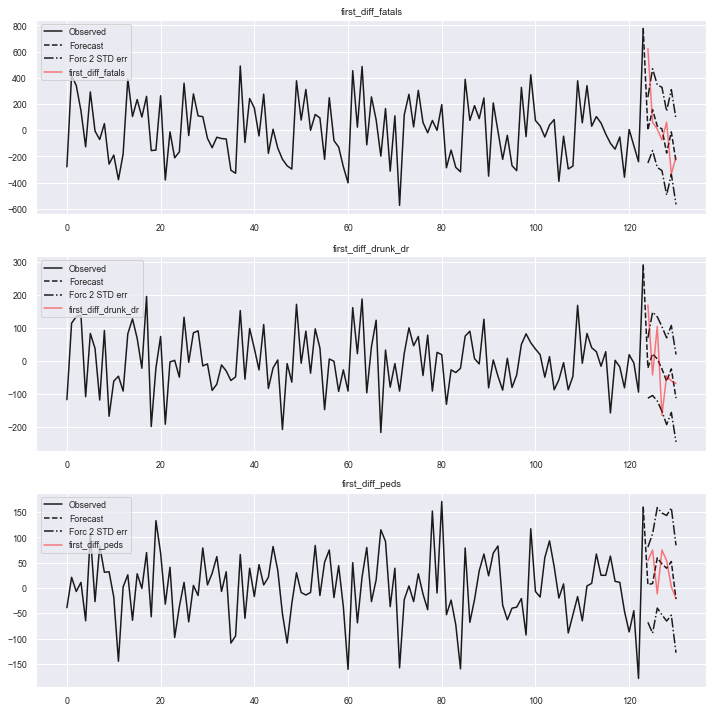

In [121]:
#Plot the forecast for the whole test set (& overlay the actual test values)
model_axes = ts_model.plot_forecast(test.shape[0]);
for i,ax in enumerate(model_axes.get_axes()):
     plot_df = test.iloc[:,i].reset_index(drop = True)
     plot_df.index += len(train)
     plot_df.plot(ax = ax, label = test.columns[i], color = 'red', alpha = 0.5)
     # zoom in 
     #plt.xlim(plot_df.index[-6], plot_df.index[-1])
     #plt.xlim(y_train.index[-15], y_test.index[-1])
     
     ax.legend(loc=2) # upper left
plt.tight_layout();

In [122]:
# Generate a forecast that matches our testing set.
ts_model.forecast(train.values, 5)

array([[   0.74874254,  -21.2657364 ,    6.41383678],
       [ 156.50045557,   21.59521995,    8.83007726],
       [  31.06036598,    6.33530024,   59.54572162],
       [   9.37833608,  -24.21251201,   47.44047008],
       [-174.82586624,  -61.29119772,   38.97049679]])

In [123]:
# See the values of our test set.
ts_model.forecast(train.values, len(test))[:10]

array([[   0.74874254,  -21.2657364 ,    6.41383678],
       [ 156.50045557,   21.59521995,    8.83007726],
       [  31.06036598,    6.33530024,   59.54572162],
       [   9.37833608,  -24.21251201,   47.44047008],
       [-174.82586624,  -61.29119772,   38.97049679],
       [ -13.17915805,  -23.99740568,   52.2032994 ],
       [-240.9954705 , -112.45493851,  -21.99908366]])

In [124]:
ts_model.dates

DatetimeIndex(['2010-02-28', '2010-03-31', '2010-04-30', '2010-05-31',
               '2010-06-30', '2010-07-31', '2010-08-31', '2010-09-30',
               '2010-10-31', '2010-11-30',
               ...
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31'],
              dtype='datetime64[ns]', name='date_time', length=124, freq='M')

In [125]:
# see values of test
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-02-28 to 2020-05-31
Freq: M
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   first_diff_fatals    124 non-null    float64
 1   first_diff_drunk_dr  124 non-null    float64
 2   first_diff_peds      124 non-null    float64
dtypes: float64(3)
memory usage: 3.9 KB


#### 6. Evaluate model (and forecasts, if possible).

In [126]:

# We'll use MSE

# Save forecasted values
forecast = ts_model.forecast(train.values, len(test))


# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test.values[:, i], y_pred=forecast[:, i]), 4)}')



The test MSE on the first_diff_fatals data is: 80446.73
The test MSE on the first_diff_drunk_dr data is: 10408.8813
The test MSE on the first_diff_peds data is: 2181.2107
The test RMSE on the first_diff_fatals data is: 283.6313
The test RMSE on the first_diff_drunk_dr data is: 102.0239
The test RMSE on the first_diff_peds data is: 46.7034


### Since we were forecasting differenced values, we may want to try undifferencing our data, that way we can compare the forecasts to the real (undifferenced) values

In [127]:
## Start by making a dataframe of our model's forecasts
forecast_df = pd.DataFrame(data = ts_model.forecast(train.values, len(test)),
                           columns = test.columns, index = test.index)

##train_forecast_df = pd.DataFrame(data = ts_model.forecast(train.values, len(train)),
#                           columns = train.columns, index = train.index)
#forecast_df.head()


In [128]:

## Then we can undifference our once-differenced columns
### We do this by taking the last value from the original column before our test data
### and adding the cumulative summed first differenced forecasts
forecast_df['forecast_fatals'] = df_model['fatals'].iloc[-len(test)-1]  + forecast_df['first_diff_fatals'].cumsum()
forecast_df['forecast_drunk_dr'] = df_model['drunk_dr'].iloc[-len(test)-1]  + forecast_df['first_diff_drunk_dr'].cumsum()
forecast_df['forecast_peds'] = df_model['peds'].iloc[-len(test)-1]  + forecast_df['first_diff_peds'].cumsum()


In [129]:
## Check out dataframe to see undifferenced forecasts
forecast_df.head()
#forecast_df.drop(columns=["forecast_realgdp"], inplace=True)


first_diff_fatals  first_diff_drunk_dr  first_diff_peds  \
date_time                                                             
2020-06-30           0.748743           -21.265736         6.413837   
2020-07-31         156.500456            21.595220         8.830077   
2020-08-31          31.060366             6.335300        59.545722   
2020-09-30           9.378336           -24.212512        47.440470   
2020-10-31        -174.825866           -61.291198        38.970497   

            forecast_fatals  forecast_drunk_dr  forecast_peds  
date_time                                                      
2020-06-30      3072.748743         797.734264     575.413837  
2020-07-31      3229.249198         819.329484     584.243914  
2020-08-31      3260.309564         825.664784     643.789636  
2020-09-30      3269.687900         801.452272     691.230106  
2020-10-31      3094.862034         740.161074     730.200603

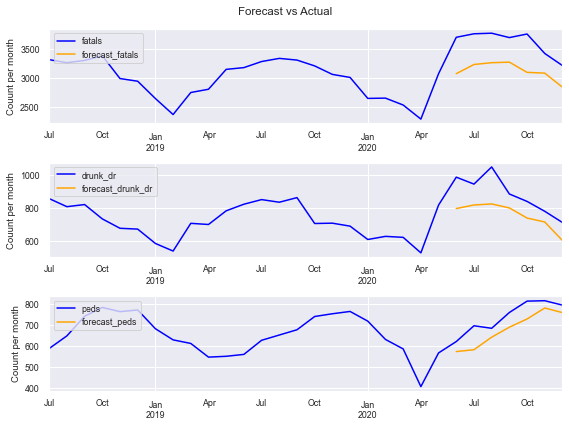

In [138]:


## Now let's plot our undifferenced forecasts against the actual values and compare
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (8,6))


for i, ax in enumerate([ax1,ax2,ax3]):
    df_model.loc[df_model.index[-30:]][df_model.columns[i]].plot(ax = ax, legend = True, color = 'blue') # show ony last 30 months
    #df_model[df_model.columns[i]].plot(ax = ax, legend = True, color = 'blue')
    forecast_df[f"forecast_{df_model.columns[i]}"].plot(ax = ax, legend = True, color = 'orange')
    ax.legend(loc=2) # upper left to avoid overlap with the graph
    ax.set_xlabel("")
    ax.set_ylabel("Couunt per month")

plt.suptitle( "Forecast vs Actual")
plt.tight_layout()


#### **Interpretation** : 
The forecast does a pretty good job in following the actual curve except where the data spikes suddenly. 


In [139]:
#Loop through columns and get RMSE for each
for i,col in enumerate(df_model.columns[:3]):
    print(f'The test RMSE on the {col} data is: {round(mean_squared_error(df_model.iloc[-len(test):, i],forecast_df.loc[:, f"forecast_{col}"], squared = False), 4)}')
    print(f'The test MAPE on the {col} data is: {round(mean_absolute_percentage_error(df_model.iloc[-len(test):, i], forecast_df.loc[:, f"forecast_{col}"]), 4)}')
    

The test RMSE on the fatals data is: 503.6641
The test MAPE on the fatals data is: 0.135
The test RMSE on the drunk_dr data is: 139.4058
The test MAPE on the drunk_dr data is: 0.1417
The test RMSE on the peds data is: 67.0919
The test MAPE on the peds data is: 0.0834


In [140]:

#baseline_RMSE
y_test_baseline_df = pd.DataFrame()

for i,col in enumerate(df_model.columns[:3]):
    y_test_baseline_df[col] = [df_model.iloc[:len(train)+1, i].mean()] * len(test)    
    print(f'The baseline RMSE on the {col} data is: {round(mean_squared_error(df_model.iloc[-len(test):, i], y_test_baseline_df[col], squared = False), 4)}')
    
    print(f'The baseline MAPE on the {col} data is: {round(mean_absolute_percentage_error(df_model.iloc[-len(test):, i], y_test_baseline_df[col]), 4)}')



The baseline RMSE on the fatals data is: 761.9811
The baseline MAPE on the fatals data is: 0.2011
The baseline RMSE on the drunk_dr data is: 158.5058
The baseline MAPE on the drunk_dr data is: 0.1391
The baseline RMSE on the peds data is: 190.0377
The baseline MAPE on the peds data is: 0.2315


In [141]:
df_model.iloc[:len(train)+1, 0].mean()

2876.352

In [142]:
df_model.iloc[-len(test):, i]

date_time
2020-06-30    623
2020-07-31    698
2020-08-31    686
2020-09-30    761
2020-10-31    815
2020-11-30    817
2020-12-31    796
Freq: M, Name: peds, dtype: int64

In [143]:
"""  # We'll use MSE

# Save forecasted values
forecast = ts_model_d.forecast(test_d.values, len(test_d))
train_forecast = ts_model_d.forecast(train_d.values, len(train_d))
#forecast = ts_model_d.forecast(train_d.values, len(test_d))

# Loop through columns and get MSE for each
for i in range(test_d.shape[1]):
    print(f'The test MSE on the {test_d.columns[i]} data is: {round(mean_squared_error(test_d.values[:, i], forecast[:, i]), 4)}')

# Loop through columns and get RMSE for each
for i in range(test_d.shape[1]):
    print(f'The test RMSE on the {test_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=forecast[:, i]), 4)}')

for i,col in enumerate(df_model.columns[:3]):
    print(f'The test RMSE on the {col} data is: {round(mean_squared_error(df_model.iloc[-len(test):, i],forecast_df.loc[:, f"forecast_{col}"], squared = False), 4)}')


# Training RMSE
for i in range(train_d.shape[1]):
    print(f'The training RMSE on the {train_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=train_d.values[:, i], y_pred=train_forecast[:, i]), 4)}')

#baseline_RMSE
y_test_baseline_df = pd.DataFrame()
#m_baseline_df = pd.DataFrame()
#metrics_df = pd.DataFrame()



for i in range(test_d.shape[1]):
    y_test_baseline_df[train_d.columns[i]] = [train_d.values[:, i].mean()] * len(test_d)    
    #m_baseline_RMSE = round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=y_test_baseline_df[train_d.columns[i]]), 4)
    
    print(f'The baseline RMSE on the {test_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=y_test_baseline_df[train_d.columns[i]]), 4)}')
  """

'  # We\'ll use MSE\n\n# Save forecasted values\nforecast = ts_model_d.forecast(test_d.values, len(test_d))\ntrain_forecast = ts_model_d.forecast(train_d.values, len(train_d))\n#forecast = ts_model_d.forecast(train_d.values, len(test_d))\n\n# Loop through columns and get MSE for each\nfor i in range(test_d.shape[1]):\n    print(f\'The test MSE on the {test_d.columns[i]} data is: {round(mean_squared_error(test_d.values[:, i], forecast[:, i]), 4)}\')\n\n# Loop through columns and get RMSE for each\nfor i in range(test_d.shape[1]):\n    print(f\'The test RMSE on the {test_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=forecast[:, i]), 4)}\')\n\nfor i,col in enumerate(df_model.columns[:3]):\n    print(f\'The test RMSE on the {col} data is: {round(mean_squared_error(df_model.iloc[-len(test):, i],forecast_df.loc[:, f"forecast_{col}"], squared = False), 4)}\')\n\n\n# Training RMSE\nfor i in range(train_d.shape[1]):\n    print(f\'The training

### Try with the weekly data to see if the model performance improves with more data

In [144]:
interpret_dftest(adfuller(df_model_week['fatals']))

Test Statistic    -5.588035
p-value            0.000001
Lag Used          13.000000
dtype: float64

In [145]:
# Stationary, don't need diff column
#df_model_week['first_diff_fatals'] = df_model_week['fatals'].diff()

In [146]:
interpret_dftest(adfuller(df_model_week['drunk_dr']))

Test Statistic   -8.852083e+00
p-value           1.563072e-14
Lag Used          1.800000e+01
dtype: float64

In [147]:
#Stationary, don't need diff column
#df_model_week['first_diff_drunk_dr'] = df_model_week['drunk_dr'].diff()

In [148]:
interpret_dftest(adfuller(df_model_week['peds']))


Test Statistic   -3.644284
p-value           0.004969
Lag Used          4.000000
dtype: float64

In [149]:
# Stationary, dont need diff column
#df_model_week['first_diff_peds'] = df_model_week['peds'].diff()

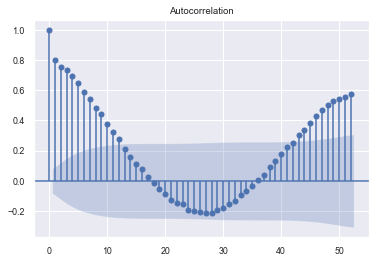

In [150]:
# One year trends - 52 weekly lags
plot_acf( df_model_week['fatals'], lags=52); # blue shaed area is confidence interval. 
# If the datapoints are outside the CI, they are statistically significant and can be used in the model


#### **Interpreation** : 
Nice trend! 
Datapoints outside the Confidence Interval (blue shaded area) can be used in the model

### Model Weekly - Train test Split

In [151]:
df_model_week.head() # dont have any diff columns, since they aren't needed

fatals  drunk_dr  peds  ve_total  persons
date_time                                            
2010-01-03     249       126    31       333      570
2010-01-10     482       133    84       707     1024
2010-01-17     552       146   113       751     1136
2010-01-24     509       149   101       711     1045
2010-01-31     493       140    99       680     1013

In [152]:

# Don't need to Subset our data. Take all 5 columns too, not sure if this impacts model performance 

#df_ts = df_model_week[['first_diff_fatals', 'first_diff_drunk_dr', 'first_diff_peds']]

# Let's get rid of rows containing missing values.
df_model_week.dropna(inplace = True)

In [153]:
train_w, test_w = train_test_split(df_model_week, shuffle=False, 
                               test_size = 0.10) # take only 10% for test

In [154]:
# Instantiate a VAR model. 

model_w = VAR(train_w, dates = train_w.index, freq='W')

In [157]:
# Fit our model and use AIC to select the value of p.

ts_model_w = model_w.fit( maxlags=52, # what is the largest possible value of p?
                     ic="aic")   # what "information criterion" (ic) will we use to decide what's "best?"

In [158]:
# What is the order of our autoregressive model? 
ts_model_w.k_ar

5

In [159]:
test_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 2019-12-01 to 2021-01-03
Freq: W-SUN
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   fatals    58 non-null     int64
 1   drunk_dr  58 non-null     int64
 2   peds      58 non-null     int64
 3   ve_total  58 non-null     int64
 4   persons   58 non-null     int64
dtypes: int64(5)
memory usage: 2.7 KB


In [160]:
# Check out the summary of our model!
ts_model_w.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 12, Apr, 2022
Time:                     00:25:24
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    33.1676
Nobs:                     512.000    HQIC:                   32.5133
Log likelihood:          -11717.9    FPE:                8.65604e+13
AIC:                      32.0914    Det(Omega_mle):     6.75706e+13
--------------------------------------------------------------------
Results for equation fatals
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             107.894767        22.665809            4.760           0.000
L1.fatals           0.456880         0.128109            3.566           0.000
L1.drunk_dr        -0.022980         0.140712           -0.163     

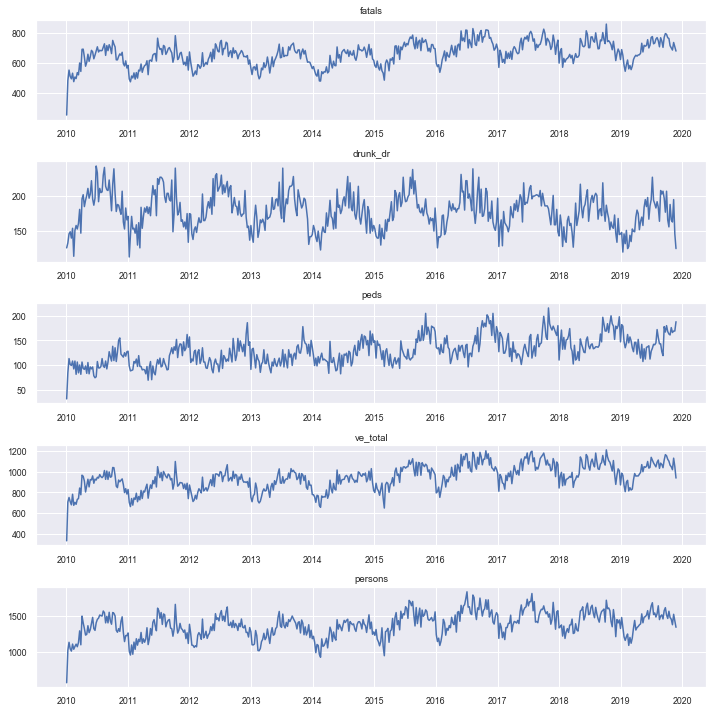

In [161]:
# Plot our training data.
ts_model_w.plot();
plt.tight_layout()

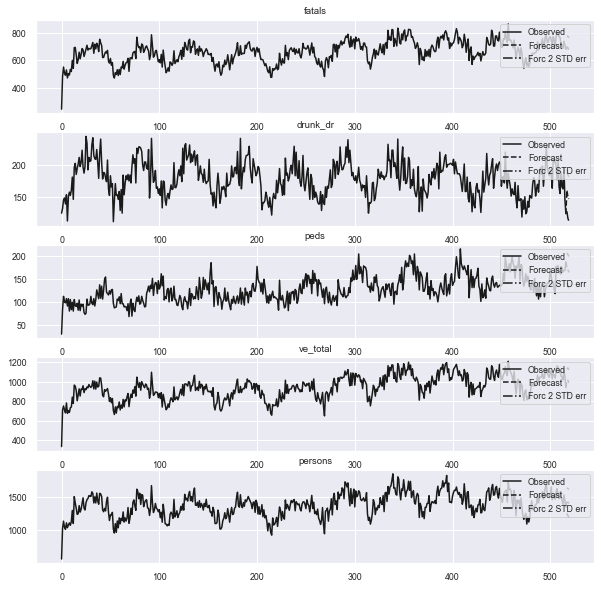

In [162]:
# Plot the forecast looking 3 steps ahead.
ts_model_w.plot_forecast(3);

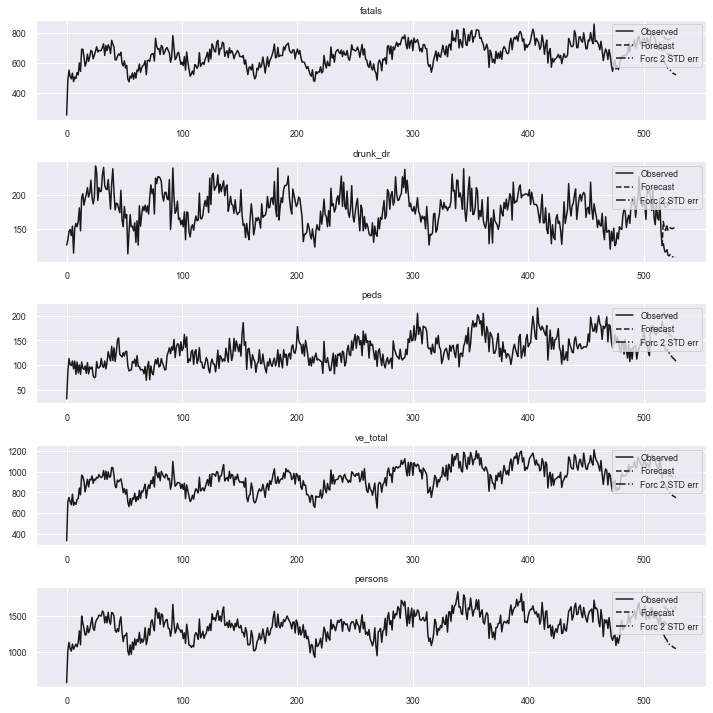

In [163]:
# Plot the forecast looking 12 steps ahead.

ts_model_w.plot_forecast(12);
plt.tight_layout()

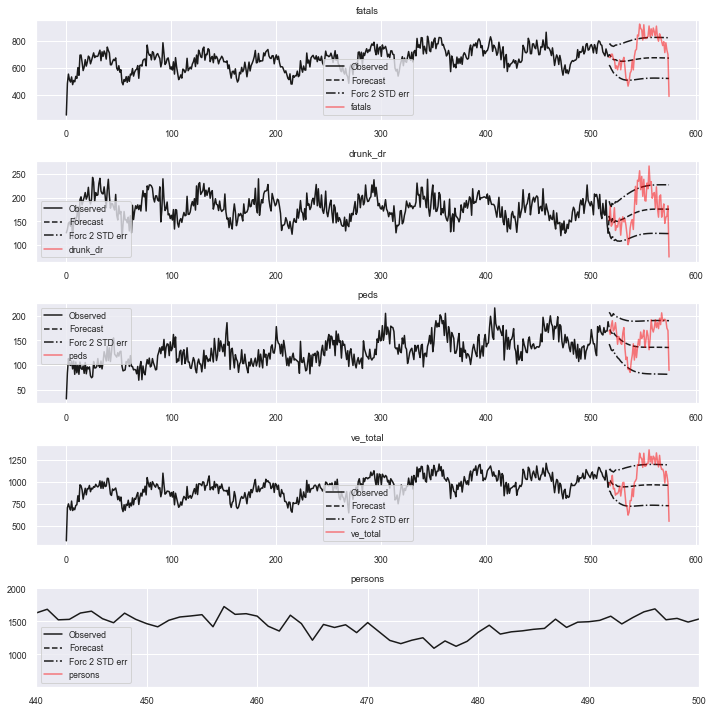

In [164]:
#Plot the forecast for the whole test set (& overlay the actual test values)
model_axes = ts_model_w.plot_forecast(test_w.shape[0]);

plt.xlim(440,500);
for i,ax in enumerate(model_axes.get_axes()):
     plot_df = test_w.iloc[:,i].reset_index(drop = True)
     plot_df.index += len(train_w)
     plot_df.plot(ax = ax, label = test_w.columns[i], color = 'red', alpha = 0.5)
     ax.legend()
     #ax.xlim(400,500)

plt.tight_layout();


In [165]:
# Generate a forecast that matches our testing set.
ts_model_w.forecast(train_w.values, 5)

array([[ 695.73194814,  160.77561811,  174.86261586, 1015.00227641,
        1443.89343356],
       [ 691.03443514,  151.47617815,  170.75836506, 1015.96565625,
        1422.2297111 ],
       [ 676.07682717,  147.58398549,  165.06726445,  989.1314885 ,
        1399.1943349 ],
       [ 668.81902963,  155.93344495,  164.6070436 ,  979.641931  ,
        1395.19895283],
       [ 659.7255991 ,  147.79238213,  167.70154579,  962.59962708,
        1341.38647463]])

In [166]:
# See the values of our test set.
ts_model_w.forecast(train_w.values, len(test_w))[:10]

array([[ 695.73194814,  160.77561811,  174.86261586, 1015.00227641,
        1443.89343356],
       [ 691.03443514,  151.47617815,  170.75836506, 1015.96565625,
        1422.2297111 ],
       [ 676.07682717,  147.58398549,  165.06726445,  989.1314885 ,
        1399.1943349 ],
       [ 668.81902963,  155.93344495,  164.6070436 ,  979.641931  ,
        1395.19895283],
       [ 659.7255991 ,  147.79238213,  167.70154579,  962.59962708,
        1341.38647463],
       [ 657.8296479 ,  148.42737733,  162.98804737,  960.92004789,
        1350.87212943],
       [ 658.58402094,  151.7034386 ,  160.23113664,  966.56292289,
        1362.66463353],
       [ 655.36173651,  150.40413521,  158.46294361,  959.84445757,
        1354.2183535 ],
       [ 649.50272177,  150.19012404,  155.74841321,  948.38965955,
        1345.31649107],
       [ 649.05330083,  151.28763989,  154.92386519,  948.41497326,
        1340.74943376]])

In [167]:
# see values of test
test_w.values[:10]

array([[ 678,  152,  170,  991, 1506],
       [ 674,  182,  162,  955, 1317],
       [ 699,  140,  180, 1012, 1434],
       [ 699,  144,  190, 1073, 1521],
       [ 662,  152,  169,  920, 1403],
       [ 660,  179,  173,  927, 1438],
       [ 594,  131,  186,  849, 1153],
       [ 613,  141,  166,  870, 1198],
       [ 584,  138,  142,  865, 1168],
       [ 622,  152,  158,  891, 1173]])

#### 6. Evaluate model (and forecasts, if possible).

In [168]:

# We'll use MSE

# Save forecasted values
forecast = ts_model_w.forecast(test_w.values, len(test_w))

# Loop through columns and get MSE for each
for i in range(test_w.shape[1]):
    print(f'The test MSE on the {test_w.columns[i]} data is: {round(mean_squared_error(test_w.values[:, i], forecast[:, i]), 4)}')

# Loop through columns and get RMSE for each
for i in range(test_w.shape[1]):
    print(f'The test RMSE on the {test_w.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_w.values[:, i], y_pred=forecast[:, i]), 4)}')



The test MSE on the fatals data is: 18678.1868
The test MSE on the drunk_dr data is: 1367.7701
The test MSE on the peds data is: 1351.0534
The test MSE on the ve_total data is: 45001.6524
The test MSE on the persons data is: 77967.5817
The test RMSE on the fatals data is: 136.6682
The test RMSE on the drunk_dr data is: 36.9834
The test RMSE on the peds data is: 36.7567
The test RMSE on the ve_total data is: 212.1359
The test RMSE on the persons data is: 279.2268


#### No undiff required. Do Forecast


In [169]:
## Start by making a dataframe of our model's forecasts
forecast_df = pd.DataFrame(data = ts_model_w.forecast(test_w.values, len(test_w)),
                           columns = test_w.columns, index = test_w.index)
                           
#forecast_df = pd.DataFrame(data = ts_model_w.forecast(train_w.values, len(test_w)),
#                           columns = test_w.columns, index = test_w.index)
forecast_df.head()


fatals    drunk_dr        peds    ve_total      persons
date_time                                                              
2019-12-01  584.040262  145.241978  160.364211  832.518580  1145.000663
2019-12-08  607.190138  147.872016  155.734727  871.242633  1209.965140
2019-12-15  564.772368  128.699136  146.897803  841.672893  1145.696817
2019-12-22  578.609589  142.459886  137.357342  843.329733  1208.162277
2019-12-29  572.127343  144.330575  129.835991  825.551655  1189.466369

In [170]:
## Check out dataframe to see undifferenced forecasts
forecast_df.head()
#forecast_df.drop(columns=["forecast_realgdp"], inplace=True)


fatals    drunk_dr        peds    ve_total      persons
date_time                                                              
2019-12-01  584.040262  145.241978  160.364211  832.518580  1145.000663
2019-12-08  607.190138  147.872016  155.734727  871.242633  1209.965140
2019-12-15  564.772368  128.699136  146.897803  841.672893  1145.696817
2019-12-22  578.609589  142.459886  137.357342  843.329733  1208.162277
2019-12-29  572.127343  144.330575  129.835991  825.551655  1189.466369

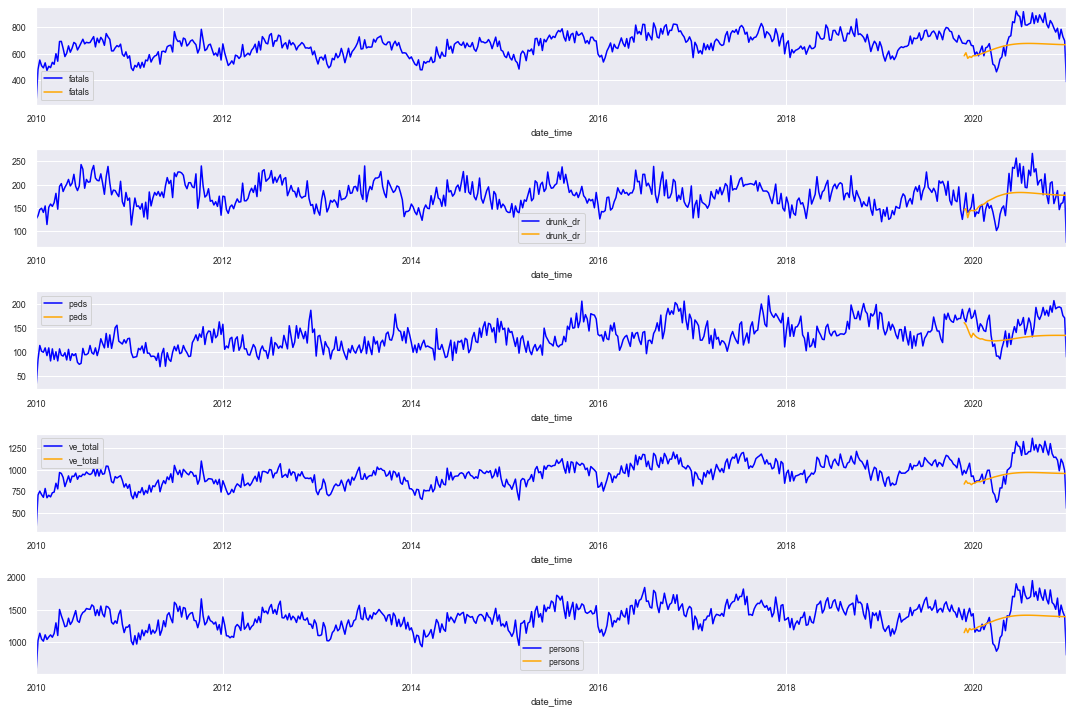

In [171]:


## Now let's plot our undifferenced forecasts against the actual values and compare
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize = (15,10))

for i, ax in enumerate([ax1,ax2,ax3, ax4, ax5]):
    df_model_week[df_model_week.columns[i]].plot(ax = ax, legend = True, color = 'blue')
    forecast_df[{df_model_week.columns[i]}].plot(ax = ax, legend = True, color = 'orange')
    #forecast_df[f"forecast_{df_model_week.columns[i]}"].plot(ax = ax, legend = True, color = 'orange')

plt.tight_layout()

In [173]:
## Then we can evaluate these using RMSE as well
#R Loop through columns and get RMSE for each
for i,col in enumerate(df_model_week.columns[:5]):
    print(f'The test RMSE on the {col} data is: {round(mean_squared_error(df_model_week.iloc[-len(test_w):, i],forecast_df.loc[:, {col}], squared = False), 4)}')
    
    

The test RMSE on the fatals data is: 136.6682
The test RMSE on the drunk_dr data is: 36.9834
The test RMSE on the peds data is: 36.7567
The test RMSE on the ve_total data is: 212.1359
The test RMSE on the persons data is: 279.2268


In [174]:
# We'll use MSE

# Save forecasted values
#forecast = ts_model_d.forecast(test_d.values, len(test_d))
#train_forecast = ts_model_d.forecast(train_d.values, len(train_d))
#forecast = ts_model_d.forecast(train_d.values, len(test_d))

forecast = ts_model_w.forecast(test_w.values, len(test_w))
train_forecast = ts_model_w.forecast(train_w.values, len(train_w))

forecast_df = pd.DataFrame(data = ts_model_w.forecast(test_w.values, len(test_w)),
                           columns = test_w.columns, index = test_w.index)



# Loop through columns and get MSE for each
for i in range(test_w.shape[1]):
    print(f'The test MSE on the {test_w.columns[i]} data is: {round(mean_squared_error(test_w.values[:, i], forecast[:, i]), 4)}')

# Loop through columns and get RMSE for each
for i in range(test_w.shape[1]):
    print(f'The test RMSE on the {test_w.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_w.values[:, i], y_pred=forecast[:, i]), 4)}')

#for i,col in enumerate(df_model_w.columns[:5]):
#    print(f'The test RMSE on the {col} data is: {round(mean_squared_error(df_model.iloc[-len(test):, i],forecast_df.loc[:, f"forecast_{col}"], squared = False), 4)}')


# Training RMSE
for i in range(train_w.shape[1]):
    print(f'The training RMSE on the {train_w.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=train_w.values[:, i], y_pred=train_forecast[:, i]), 4)}')

#baseline_RMSE
y_test_baseline_df = pd.DataFrame()
#m_baseline_df = pd.DataFrame()


for i in range(test_w.shape[1]):
    y_test_baseline_df[train_w.columns[i]] = [train_w.values[:, i].mean()] * len(test_w)    
    print(f'The baseline RMSE on the {test_w.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_w.values[:, i], y_pred=y_test_baseline_df[train_w.columns[i]]), 4)}')


The test MSE on the fatals data is: 18678.1868
The test MSE on the drunk_dr data is: 1367.7701
The test MSE on the peds data is: 1351.0534
The test MSE on the ve_total data is: 45001.6524
The test MSE on the persons data is: 77967.5817
The test RMSE on the fatals data is: 136.6682
The test RMSE on the drunk_dr data is: 36.9834
The test RMSE on the peds data is: 36.7567
The test RMSE on the ve_total data is: 212.1359
The test RMSE on the persons data is: 279.2268
The training RMSE on the fatals data is: 79.9684
The training RMSE on the drunk_dr data is: 25.9543
The training RMSE on the peds data is: 30.3973
The training RMSE on the ve_total data is: 123.9348
The training RMSE on the persons data is: 175.2862
The baseline RMSE on the fatals data is: 142.8255
The baseline RMSE on the drunk_dr data is: 41.4593
The baseline RMSE on the peds data is: 40.0053
The baseline RMSE on the ve_total data is: 221.1654
The baseline RMSE on the persons data is: 292.9565


In [ ]:
#### Not sure why weekly grpahs are not good....


### Try daily data; only 3 cols, not the 5 that we used for weekly; 

### Try with the daily data to see if the model performance improves with more data

### Now lets look at the daily data; and then compare with the monthly time series. 
#### We will also use the daily time series model to contrast with the daily RNN model (in the next notebook)


In [176]:
interpret_dftest(adfuller(df_model_day['fatals'])) #stationary 

Test Statistic    -3.970957
p-value            0.001570
Lag Used          29.000000
dtype: float64

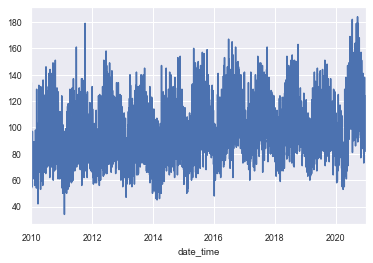

In [177]:
df_model_day['fatals'].plot();

In [178]:
interpret_dftest(adfuller(df_model_day['drunk_dr'])) #stationary        

Test Statistic    -4.812332
p-value            0.000052
Lag Used          29.000000
dtype: float64

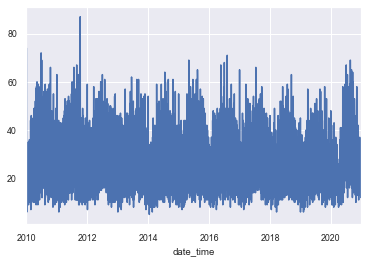

In [179]:
df_model_day['drunk_dr'].plot();

In [180]:
interpret_dftest(adfuller(df_model_day['peds'])) # stationary

Test Statistic    -3.696793
p-value            0.004158
Lag Used          29.000000
dtype: float64

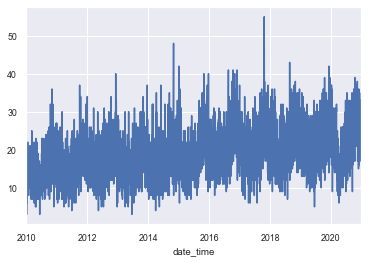

In [181]:
df_model_day['peds'].plot();

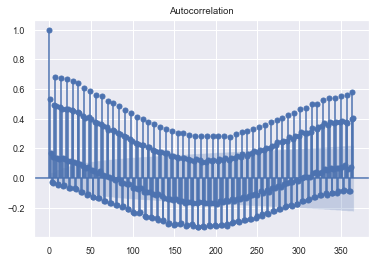

In [182]:
# One year trends

plot_acf( df_model_day['fatals'], lags=365); # blue shaed area is confidence interval. 
# If the datapoints are outside the CI, they are statistically significant and can be used in the model


#### **Interpreation** : 
Nice trend! 
Datapoints outside the Confidence Interval (blue shaded area) can be used in the model

### Model Weekly - Train test Split

In [183]:
df_model_day.info() # dont have any diff columns, since they aren't needed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2010-01-01 to 2020-12-31
Freq: D
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   fatals    4018 non-null   int64
 1   drunk_dr  4018 non-null   int64
 2   peds      4018 non-null   int64
 3   ve_total  4018 non-null   int64
 4   persons   4018 non-null   int64
dtypes: int64(5)
memory usage: 188.3 KB


In [184]:

# Don't need to Subset our data. Take all 5 columns too, not sure if this impacts model performance 

#df_ts = df_model_week[['first_diff_fatals', 'first_diff_drunk_dr', 'first_diff_peds']]


#df_model_day.drop(columns="first_diff_fatals", inplace = True)
# Let's get rid of rows containing missing values.
df_model_day.dropna(inplace = True)

In [185]:
train_d, test_d = train_test_split(df_model_day, shuffle=False, 
                               test_size = 0.1) # take only 10% for test

In [186]:
test_d

fatals  drunk_dr  peds  ve_total  persons
date_time                                            
2019-11-26      95        17    17       155      218
2019-11-27     105        26    29       151      223
2019-11-28      95        24    22       125      233
2019-11-29      99        18    29       137      206
2019-11-30      99        32    28       139      226
...            ...       ...   ...       ...      ...
2020-12-27      98        27    21       128      201
2020-12-28      98        12    17       140      198
2020-12-29      88        16    22       126      194
2020-12-30      96        26    20       129      164
2020-12-31     105        21    30       158      241

[402 rows x 5 columns]

In [187]:
# Instantiate a VAR model. 

model_d = VAR(train_d, dates = train_d.index, freq='D')

In [188]:
# Fit our model and use AIC to select the value of p.

ts_model_d = model_d.fit( maxlags=30, # what is the largest possible value of p?
                     ic="aic")   # what "information criterion" (ic) will we use to decide what's "best?"

In [189]:
# What is the order of our autoregressive model? 
ts_model_d.k_ar

28

In [190]:
# Check out the summary of our model!
ts_model_d.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 12, Apr, 2022
Time:                     00:29:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    22.5009
Nobs:                     3588.00    HQIC:                   21.7188
Log likelihood:          -62937.0    FPE:                1.75504e+09
AIC:                      21.2856    Det(Omega_mle):     1.44740e+09
--------------------------------------------------------------------
Results for equation fatals
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               13.119957         2.494236            5.260           0.000
L1.fatals            0.136673         0.042677            3.202           0.001
L1.drunk_dr         -0.031392         0.040428           -0.776

In [191]:
ts_model_d.names

['fatals', 'drunk_dr', 'peds', 've_total', 'persons']

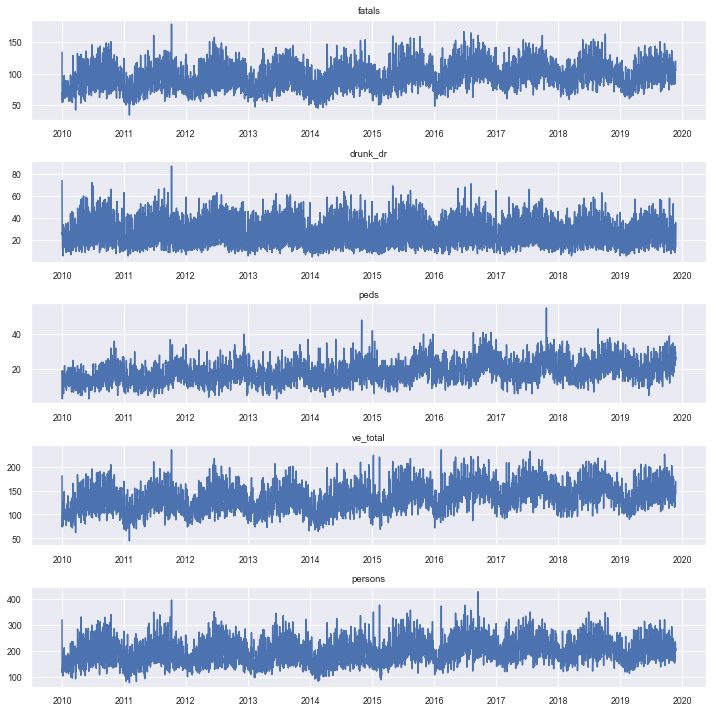

In [192]:
# Plot our training data.
ts_model_d.plot();
plt.tight_layout()

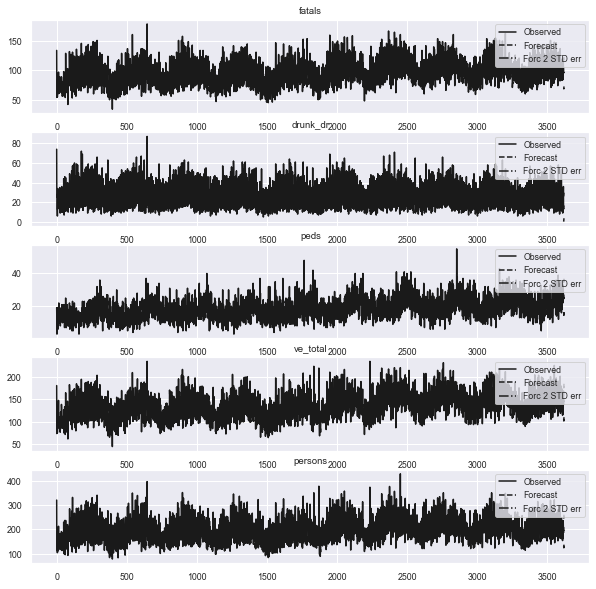

In [193]:
# Plot the forecast looking 3 steps ahead.
ts_model_d.plot_forecast(3);

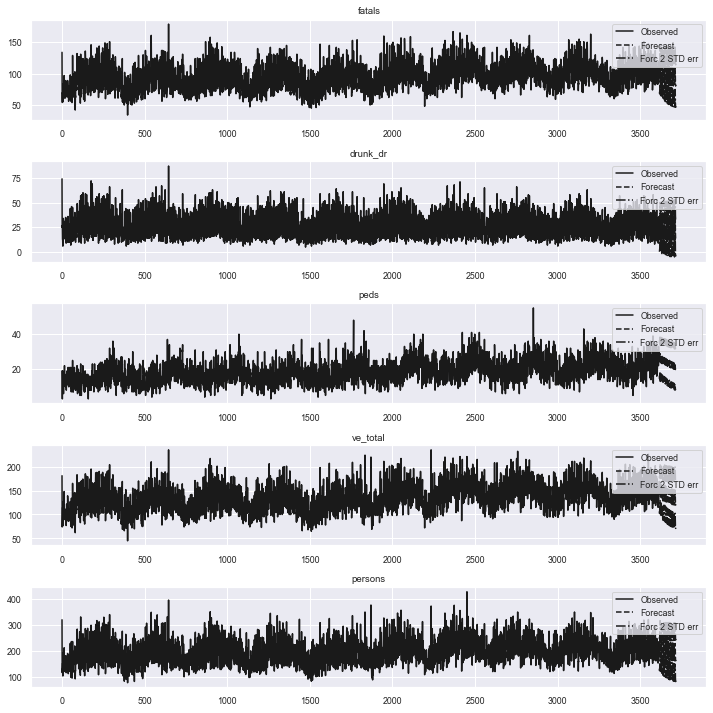

In [194]:
# Plot the forecast looking 12 steps ahead.

ts_model_d.plot_forecast(100);
plt.tight_layout()


In [195]:
#plot_df = test_d.iloc[:,i].reset_index(drop = True)

#plot_df

#plot_df.index += len(train_d)
plot_df.index.values
#len(train_d)


array([517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529,
       530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542,
       543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555,
       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
       569, 570, 571, 572, 573, 574])

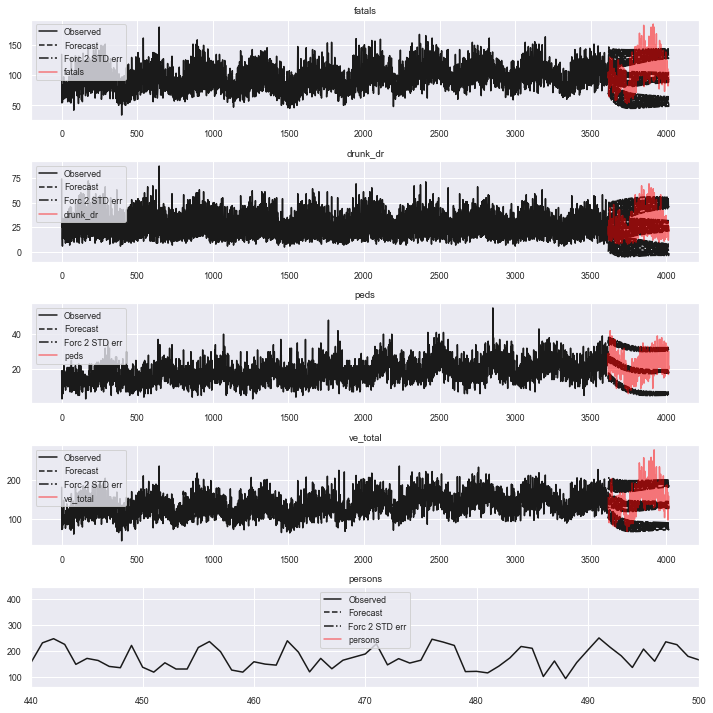

In [196]:
#Plot the forecast for the whole test set (& overlay the actual test values)
model_axes = ts_model_d.plot_forecast(test_d.shape[0]);

plt.xlim(440,500);
for i,ax in enumerate(model_axes.get_axes()):
     plot_df = test_d.iloc[:,i].reset_index(drop = True)
     plot_df.index += len(train_d)
     plot_df.plot(ax = ax, label = test_d.columns[i], color = 'red', alpha = 0.5) # red is actuals y_test
     ax.legend()
     #ax.xlim(400,500)

plt.tight_layout();


In [197]:

ts_model_d.forecast( train_d.values, 5)

array([[ 94.22974958,  13.14517617,  26.42876301, 143.12235312,
        192.70280866],
       [ 93.33380347,  14.88190802,  24.58254265, 139.07923258,
        185.58844388],
       [ 97.53302834,  16.7449176 ,  26.58977767, 147.76358977,
        198.75727818],
       [111.24192816,  25.46633607,  28.93039215, 161.19269735,
        227.168635  ],
       [121.31983327,  37.25378995,  28.49596238, 167.84113389,
        255.85049609]])

In [198]:
# Generate a forecast that matches our testing set.
ts_model_d.forecast(train_d.values, len(test_d))[:10]

array([[ 94.22974958,  13.14517617,  26.42876301, 143.12235312,
        192.70280866],
       [ 93.33380347,  14.88190802,  24.58254265, 139.07923258,
        185.58844388],
       [ 97.53302834,  16.7449176 ,  26.58977767, 147.76358977,
        198.75727818],
       [111.24192816,  25.46633607,  28.93039215, 161.19269735,
        227.168635  ],
       [121.31983327,  37.25378995,  28.49596238, 167.84113389,
        255.85049609],
       [108.24810642,  36.16579224,  23.27777091, 149.49057849,
        229.8372381 ],
       [ 91.62749983,  15.61482356,  23.52809362, 136.87447605,
        187.44650367],
       [ 93.62330449,  14.69329153,  26.13320528, 142.89445069,
        189.21552562],
       [ 90.48247245,  14.93890199,  23.32118776, 136.99195531,
        184.82305341],
       [ 91.41947164,  14.2408942 ,  25.41446261, 144.14626071,
        184.34391446]])

In [199]:
# Generate a forecast that matches our testing set.
ts_model_d.forecast(test_d.values, len(test_d))[:10]

array([[104.83895372,  27.37920017,  24.45706127, 149.90449299,
        215.61676357],
       [106.51301658,  28.97025563,  26.32408873, 148.25773921,
        220.43479906],
       [103.33126561,  30.30647182,  23.4497885 , 143.59935499,
        212.45967115],
       [ 91.65352238,  17.99041386,  23.58086989, 131.60437202,
        187.82497441],
       [ 89.77130598,  15.88417618,  22.3823832 , 131.69494237,
        177.03007176],
       [ 95.10114629,  20.0469702 ,  23.53903003, 140.57858175,
        195.50220647],
       [100.73822715,  20.88819664,  24.88063138, 146.97464146,
        205.11684055],
       [105.04921363,  26.46255264,  24.33684196, 151.56650492,
        216.4012226 ],
       [108.28885636,  29.65084596,  25.808295  , 155.52416386,
        228.49829329],
       [104.37437846,  29.04645328,  23.26951872, 145.04552387,
        215.76826713]])

In [200]:
# see values of test
test_d.values[:10]

array([[ 95,  17,  17, 155, 218],
       [105,  26,  29, 151, 223],
       [ 95,  24,  22, 125, 233],
       [ 99,  18,  29, 137, 206],
       [ 99,  32,  28, 139, 226],
       [ 80,  21,  18, 115, 191],
       [ 64,  12,  20,  91, 112],
       [ 77,  14,  20, 116, 160],
       [ 95,  20,  27, 154, 190],
       [ 98,  21,  23, 144, 191]])

#### 6. Evaluate model (and forecasts, if possible).

In [201]:

# We'll use MSE

# Save forecasted values
forecast = ts_model_d.forecast(test_d.values, len(test_d))
train_forecast = ts_model_d.forecast(train_d.values, len(train_d))
#forecast = ts_model_d.forecast(train_d.values, len(test_d))

# Loop through columns and get MSE for each
for i in range(test_d.shape[1]):
    print(f'The test MSE on the {test_d.columns[i]} data is: {round(mean_squared_error(test_d.values[:, i], forecast[:, i]), 4)}')

# Loop through columns and get RMSE for each
for i in range(test_d.shape[1]):
    print(f'The test RMSE on the {test_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=forecast[:, i]), 4)}')

# Training RMSE
for i in range(train_d.shape[1]):
    print(f'The training RMSE on the {train_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=train_d.values[:, i], y_pred=train_forecast[:, i]), 4)}')

#baseline_RMSE
y_test_baseline_df = pd.DataFrame()
#m_baseline_df = pd.DataFrame()
#metrics_df = pd.DataFrame()



for i in range(test_d.shape[1]):
    y_test_baseline_df[train_d.columns[i]] = [train_d.values[:, i].mean()] * len(test_d)    
    #m_baseline_RMSE = round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=y_test_baseline_df[train_d.columns[i]]), 4)
    
    print(f'The baseline RMSE on the {test_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=y_test_baseline_df[train_d.columns[i]]), 4)}')



The test MSE on the fatals data is: 832.8433
The test MSE on the drunk_dr data is: 205.5831
The test MSE on the peds data is: 55.8104
The test MSE on the ve_total data is: 1697.1847
The test MSE on the persons data is: 3933.5474
The test RMSE on the fatals data is: 28.859
The test RMSE on the drunk_dr data is: 14.3382
The test RMSE on the peds data is: 7.4706
The test RMSE on the ve_total data is: 41.1969
The test RMSE on the persons data is: 62.718
The training RMSE on the fatals data is: 22.3007
The training RMSE on the drunk_dr data is: 13.9881
The training RMSE on the peds data is: 6.6164
The training RMSE on the ve_total data is: 29.7321
The training RMSE on the persons data is: 52.4416
The baseline RMSE on the fatals data is: 26.7651
The baseline RMSE on the drunk_dr data is: 12.3286
The baseline RMSE on the peds data is: 7.7439
The baseline RMSE on the ve_total data is: 39.3046
The baseline RMSE on the persons data is: 58.1743


In [202]:
m_baseline_RMSE

NameError: name 'm_baseline_RMSE' is not defined

34.231301861724596

In [ ]:
y_test_baseline_df = pd.DataFrame()

# Baseline RMSE
for i in range(test_d.shape[1]):
    y_test_baseline_df[train_d.columns[i]] = [train_d.values[:, i].mean()] * len(test_d)    
    print(f'The baseline RMSE on the {test_d.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test_d.values[:, i], y_pred=y_test_baseline_df[train_d.columns[i]]), 4)}')


The baseline RMSE on the fatals data is: 26.769
The baseline RMSE on the drunk_dr data is: 12.3285
The baseline RMSE on the peds data is: 7.744
The baseline RMSE on the ve_total data is: 39.3096
The baseline RMSE on the persons data is: 58.1818


In [ ]:
#empt_array = np.empty((402,5), float)

i=1
#baseline_df = pd.DataFrame()
y_test_baseline_df
#y_test_baseline_df[train_d.columns[i]]

#baseline_df[train_d.columns[i]] = [train_d.values[:, i].mean()] * len(test_d)


#empt_array[i] = [train_d.values[:, i].mean()] * len(test_d)


fatals   drunk_dr      peds    ve_total     persons
0    94.800277  25.555187  18.48686  135.123375  197.773167
1    94.800277  25.555187  18.48686  135.123375  197.773167
2    94.800277  25.555187  18.48686  135.123375  197.773167
3    94.800277  25.555187  18.48686  135.123375  197.773167
4    94.800277  25.555187  18.48686  135.123375  197.773167
..         ...        ...       ...         ...         ...
397  94.800277  25.555187  18.48686  135.123375  197.773167
398  94.800277  25.555187  18.48686  135.123375  197.773167
399  94.800277  25.555187  18.48686  135.123375  197.773167
400  94.800277  25.555187  18.48686  135.123375  197.773167
401  94.800277  25.555187  18.48686  135.123375  197.773167

[402 rows x 5 columns]

In [ ]:
i=0
type(test_d.values[:, i])

#train_d.columns[i]
#train_d.values[:, i].mean()

#len(forecast.values[:, 0])

numpy.ndarray

In [203]:
train_d

fatals  drunk_dr  peds  ve_total  persons
date_time                                            
2010-01-01     134        74    19       181      321
2010-01-02      61        25     9        74      117
2010-01-03      54        27     3        78      132
2010-01-04      70        13     9       104      136
2010-01-05      68        12    19       115      154
...            ...       ...   ...       ...      ...
2019-11-21      88        10    33       117      164
2019-11-22     105        19    28       154      236
2019-11-23     120        29    30       144      227
2019-11-24     105        36    25       143      200
2019-11-25     105        14    27       169      209

[3616 rows x 5 columns]

In [204]:
[train_d.values[:, i].mean()] * len(test_d)
#y_test_baseline[0][0]
#y_test_baseline[:, 0]

[197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557522123,
 197.80724557

#### No undiff required. Do Forecast


In [205]:
## Start by making a dataframe of our model's forecasts
forecast_df = pd.DataFrame(data = ts_model_w.forecast(train_w.values, len(test_w)),
                           columns = test_w.columns, index = test_w.index)
forecast_df.head()


fatals    drunk_dr        peds     ve_total      persons
date_time                                                               
2019-12-01  695.731948  160.775618  174.862616  1015.002276  1443.893434
2019-12-08  691.034435  151.476178  170.758365  1015.965656  1422.229711
2019-12-15  676.076827  147.583985  165.067264   989.131489  1399.194335
2019-12-22  668.819030  155.933445  164.607044   979.641931  1395.198953
2019-12-29  659.725599  147.792382  167.701546   962.599627  1341.386475

In [206]:
# Dont need to undiff, since we never diffed...

""" 
## Then we can undifference our once-differenced columns
### We do this by taking the last value from the original column before our test data
### and adding the cumulative summed first differenced forecasts
forecast_df['forecast_fatals'] = df_model['fatals'].iloc[-len(test)-1]  + forecast_df['first_diff_fatals'].cumsum()
forecast_df['forecast_drunk_dr'] = df_model['drunk_dr'].iloc[-len(test)-1]  + forecast_df['first_diff_drunk_dr'].cumsum()
forecast_df['forecast_peds'] = df_model['peds'].iloc[-len(test)-1]  + forecast_df['first_diff_peds'].cumsum()
 """

" \n## Then we can undifference our once-differenced columns\n### We do this by taking the last value from the original column before our test data\n### and adding the cumulative summed first differenced forecasts\nforecast_df['forecast_fatals'] = df_model['fatals'].iloc[-len(test)-1]  + forecast_df['first_diff_fatals'].cumsum()\nforecast_df['forecast_drunk_dr'] = df_model['drunk_dr'].iloc[-len(test)-1]  + forecast_df['first_diff_drunk_dr'].cumsum()\nforecast_df['forecast_peds'] = df_model['peds'].iloc[-len(test)-1]  + forecast_df['first_diff_peds'].cumsum()\n "

In [207]:
## Check out dataframe to see undifferenced forecasts
forecast_df.head()
#forecast_df.drop(columns=["forecast_realgdp"], inplace=True)


fatals    drunk_dr        peds     ve_total      persons
date_time                                                               
2019-12-01  695.731948  160.775618  174.862616  1015.002276  1443.893434
2019-12-08  691.034435  151.476178  170.758365  1015.965656  1422.229711
2019-12-15  676.076827  147.583985  165.067264   989.131489  1399.194335
2019-12-22  668.819030  155.933445  164.607044   979.641931  1395.198953
2019-12-29  659.725599  147.792382  167.701546   962.599627  1341.386475

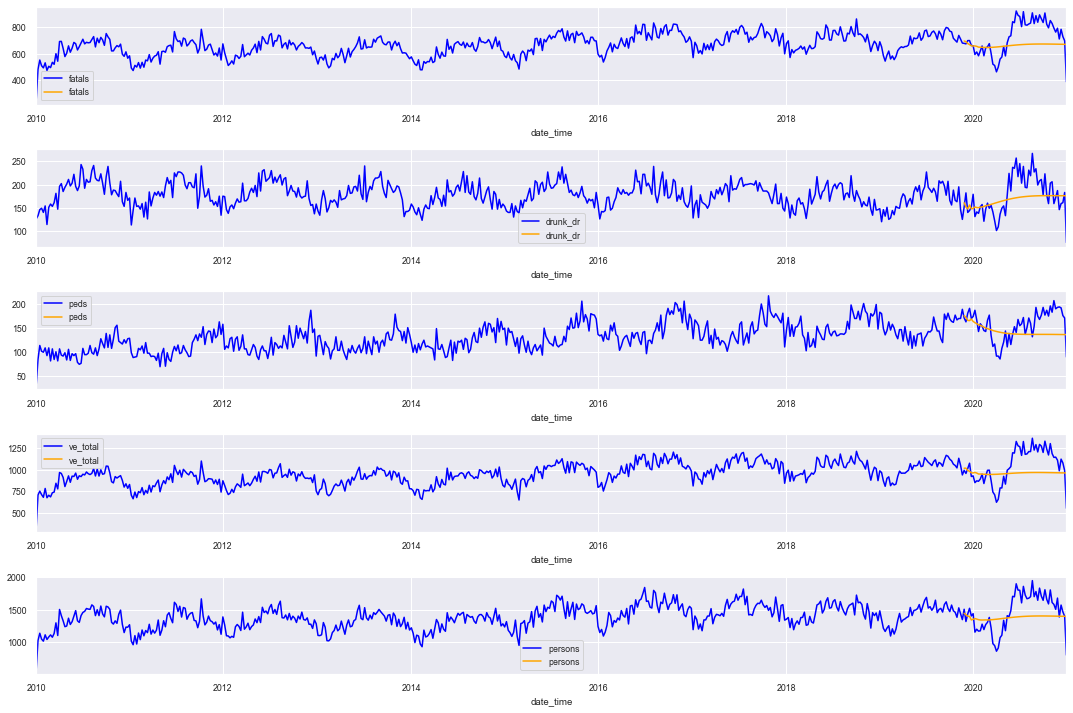

In [208]:


## Now let's plot our undifferenced forecasts against the actual values and compare
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize = (15,10))

for i, ax in enumerate([ax1,ax2,ax3, ax4, ax5]):
    df_model_week[df_model_week.columns[i]].plot(ax = ax, legend = True, color = 'blue')
    forecast_df[{df_model_week.columns[i]}].plot(ax = ax, legend = True, color = 'orange')
    #forecast_df[f"forecast_{df_model_week.columns[i]}"].plot(ax = ax, legend = True, color = 'orange')

plt.tight_layout()

In [209]:
## Then we can evaluate these using RMSE as well
#R Loop through columns and get RMSE for each
for i,col in enumerate(df_model_week.columns[:5]):
    print(f'The test RMSE on the {col} data is: {round(mean_squared_error(df_model_week.iloc[-len(test_w):, i],forecast_df.loc[:, {col}], squared = False), 4)}')
    
    

The test RMSE on the fatals data is: 136.7552
The test RMSE on the drunk_dr data is: 38.3753
The test RMSE on the peds data is: 33.4905
The test RMSE on the ve_total data is: 210.4309
The test RMSE on the persons data is: 278.6723


In [210]:
#### Not sure why daily grpahs are not good....
